In [1]:
%matplotlib inline

In [29]:
import numpy as np
import collections
import itertools
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.linalg
import scipy.stats
import functools
import json

#Maximum likelihood and Expectation Maximisation

## Maximum likelihood estimation for a single multivariate gaussian distribution

We have some samples which we suspect were generated from a single multivariate gaussian distribution, and we want to estimate the parameters of the distribution.

Here are our samples:

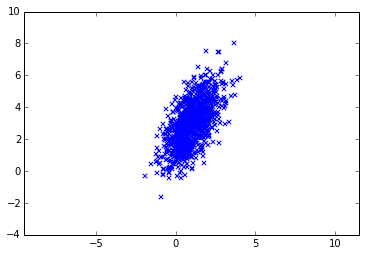

In [30]:
m = np.array([1.0, 3.0])
cov = 0.8
C = np.array([[0.8, cov],
              [cov, 2.0]])

S = scipy.linalg.cholesky(C)
X = (np.random.normal(size=(1000, 2))).dot(S)+m

plt.scatter(X[:,0], X[:,1], marker='x')
plt.axes().set_aspect('equal', 'datalim')

$\newcommand{\l}{\mathscr{l}}$
$\newcommand{\x}{\mathbf{x}}$
$\newcommand{\X}{\mathbf{X}}$
$\newcommand{\Mu}{\mathbf{\mu}}$
$\newcommand{\T}{\mathrm{T}}$
$\newcommand{\C}{\mathbf{\Sigma}}$
The data is drawn from a gaussian distribution: $\X \sim N(\Mu, \C)$. We want to find the parameters $\Mu$ and $\C$ which maximise the likelihood of generating our data X, i.e. we want to find:

$$\arg\max_{\Mu, \C} l(\Mu, \C | \X)$$

where the likelihood function $l(\theta)$ is the product of the probability of generating every point:

$$ l(\Mu,\C | \X) = \prod_{n=1}^N f(\x_n | \Mu, \C) $$

And $f(\x | \Mu, \C)$ is the p.d.f of $N$. Alternatively, we can minimise the log-liklhood:

$$\arg\min_{\Mu, \C} \l(\Mu, \C | \X)$$

where $\l(\cdot) = \log(l(\cdot))$.

We know that the pdf of a $k$-dimensional multivariate normal distribution  is:

$$f(x_1, \ldots, x_k) = \frac{1}{\sqrt{(2 \pi)^k \det(\C)}}  \exp \left( -\frac{1}{2}(\x - \Mu)^\T \C^{-1} (\x -\Mu) \right)$$

so $f(\x | \Mu, \C)$ gives the probability of a particular sample.

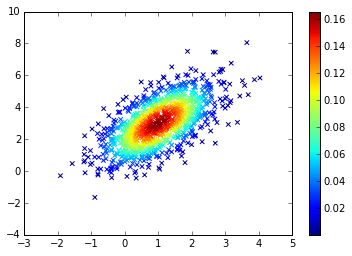

In [32]:
# Define the Normal PDF
def normalPDF(x, mu, sigma):
    k = len(x)
    p1 = 1.0 / (np.sqrt(2.0 * np.pi)**k * np.linalg.det(sigma))
    p2 = np.exp( -0.5 * (x-mu).T.dot(np.linalg.inv(sigma)).dot(x-mu))
    return p1 * p2
# And a version which acts on arrays
def NormalPDF(X, mu, sigma):
    return np.apply_along_axis(normalPDF, 1, X, mu, sigma)

# Plot the data, and the pdf value of the distribution at each point
plt.scatter(X[:,0], X[:,1], marker='x', c=NormalPDF(X, m, C))
plt.colorbar()
plt.show()

The likelihood of some data $X$ being produced by a gaussian distribution with parameters $\mu$ and $\Sigma$ is given by the sum of all probabilities:

$$\begin{align}
l(\Mu,\C | \X) = \prod_{n=1}^N  \frac{1}{\sqrt{(2 \pi)^{kN} \det(\C)^N}}  \exp \left( -\frac{1}{2}(\x - \Mu)^\T \C^{-1} (\x -\Mu) \right)
\end{align}
$$

However, it's easier to work with *log* probabilities, since the product becomes a sum. Thus, the average log-likelihood is given by:

$$
\l(\Mu,\C | \X) = \log\left(\prod_{n=1}^N f(\x_n)\right) = \sum_{n=1}^N \log \left( f(\x_n | \Mu, \C) \right)
$$

and the new objective is to find the parameters which $minimise$ the log-likelihood function: $\arg\min_{\Mu, \C} \l(\Mu, \C | \X)$

For the gaussian distribution, the log-likelihood function found by taking the log of the p.d.f:
$$
\l(\Mu, \C | \X) = K + -\sum_{n=1}^N \frac{1}{2}(\x_n - \Mu)^\T \C^{-1} (\x_n -\Mu) + \frac{N}{2}\log \left( 2 \pi \det(\C) \right) 
$$
where $K$ is a constant dependant only on $k$.

The parameters will take optimal values at the minimum, when $\frac{\partial}{\partial\Mu}\l(\mu,\C) = \frac{\partial}{\partial\C^{-1}}\l(\mu,\C) = 0$. For $\Mu$, the optimal value is the mean of each dimension:

$$\begin{align}
\frac{\partial}{\partial\Mu}\l(\mu,\C) &= \sum_n \C^{-1}\x_n - N\Mu\C^{-1} \\
\Rightarrow \Mu &= \frac{1}{N}\sum_n \X^n \end{align}
$$

For $\C$, the optimal value is the covariance matrix of the data:
$$\C = \frac{1}{N} \sum_{n=1}^N (\x_n - \Mu)^\T (\x_n - \Mu)$$


In [33]:
# Estimate the parameters of the gaussian distribution
# from the data
em_mean = np.mean(X, axis=0)
em_cov = np.cov(X.T)
print "Mean:\n{}\nCovariance:\n{}\n".format(em_mean, em_cov)

Mean:
[ 1.00662872  2.99873979]
Covariance:
[[ 0.81714326  0.79501442]
 [ 0.79501442  1.99511857]]



We can see that the estimate parameters seem to fit nicely!

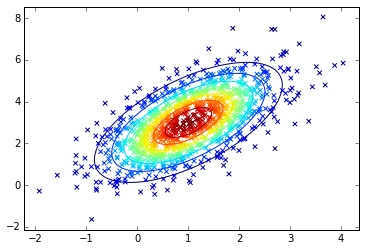

In [34]:
# Plot the data
plt.scatter(X[:,0], X[:,1], marker='x', c=NormalPDF(X, m, C))
# Plot the contour of the estimated gaussian distribution
x, y = np.mgrid[-1:3:0.1, -1:7:0.1]
xflat = x.flatten()
yflat = y.flatten().T
Z = NormalPDF(np.vstack((xflat, yflat)).T, em_mean, em_cov)
Z = Z.reshape(x.shape)
plt.contour(x, y, Z)
plt.show()

To demonstrate the effect of badly estimated parameters on the log-likelihood, notice that changing any parameter when evaluating $\sum_n\log(f(\x_n|\Mu, \C))$ makes the log-likelihood go up.

In [35]:
print "Real      ", np.sum(np.log(NormalPDF(X, m, C)))
print "Estimated ", np.sum(np.log(NormalPDF(X, em_mean, em_cov)))
print "Bad mean  ", np.sum(np.log(NormalPDF(X+1, m+1.5, C)))
print "Bad cov   ", np.sum(np.log(NormalPDF(X, m, C+0.2)))

Real       -2816.06676489
Estimated  -2835.12528603
Bad mean   -2968.17381318
Bad cov    -2937.16405947


Also note that we can't evaluate $\prod_n f(x_n|\Mu,\C)$ because the values are too small to compute.

In [36]:
print np.prod(NormalPDF(X, m, C))

0.0


## EM for a mixture of multivariate gaussian distributions

This is a real dataset representing the behaivour of the Old Faitful geyser's eruptions. It consists of two separate distributions.

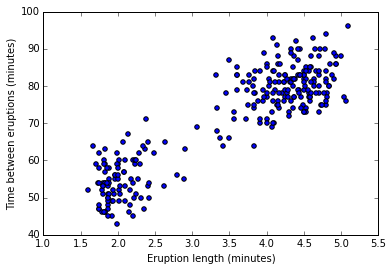

In [37]:
X = np.array(json.load(open('oldfaithful.json')))
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel('Eruption length (minutes)')
plt.ylabel('Time between eruptions (minutes)')
plt.show()

$$
Each $i^{th}$ distribution has a weighting $\tau_i$. The vector $Z_i$ holds the membership of each point, so for two distributions:

$$\begin{align}
P(Z_i = 1) &= \tau_1, \\
P(Z_i = 2) &= \tau_2 = (1 - \tau_1).
\end{align}$$


In [64]:
Theta = collections.namedtuple('Theta', ['w', 'mu', 'sigma'])
def T(x, j, params):
    top = params[j].w * normalPDF(x, params[j].mu, params[j].sigma)
    bottom = np.sum(p.w * normalPDF(x, p.mu, p.sigma)
                    for p in params)
    return top / bottom

In [99]:

def next_params(X, k, params):
    Ts = [T(x, k, params) for x in X]
    sumTs = np.sum(Ts)
    next_mu = np.sum(t*x for t, x in zip(Ts, X)) / sumTs
    next_w = sumTs / len(X)
    next_sigma = (Ts*(X - next_mu).T).dot((X - next_mu)) / sumTs

    return Theta(next_w, next_mu, next_sigma)

params = [
    Theta(0.5, [1, 70], np.eye(2)),
    Theta(0.5, [5, 70], np.eye(2)),
]

for iter in range(5):
    params = [next_params(X, k, params) for k in range(len(params))]

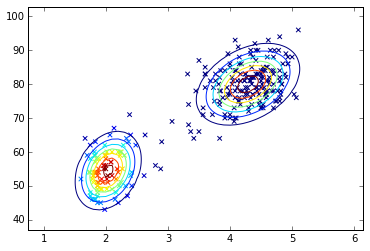

In [100]:
# Plot the data
plt.scatter(X[:,0], X[:,1], marker='x', c=NormalPDF(X, params[0].mu, params[0].sigma))
# Plot the contour of the estimated gaussian distribution
x, y = np.mgrid[1:6:0.1, 40:100:0.1]
xflat = x.flatten()
yflat = y.flatten().T
Z = NormalPDF(np.vstack((xflat, yflat)).T, params[0].mu, params[0].sigma)
Z = Z.reshape(x.shape)
plt.contour(x, y, Z)

x, y = np.mgrid[1:6:0.1, 40:100:0.1]
xflat = x.flatten()
yflat = y.flatten().T
Z = NormalPDF(np.vstack((xflat, yflat)).T, params[1].mu, params[1].sigma)
Z = Z.reshape(x.shape)



plt.contour(x, y, Z)
plt.show()